In [1]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


2023-04-24 18:30:52.536204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 18:30:52.613255: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
IMAGE_DIR = "/data2/SrikanthData/ResearchWork2/tensorflow/Project/img_data/REFUGE/test/Images"

MASK_DIR = "/data2/SrikanthData/ResearchWork2/tensorflow/Project/img_data/REFUGE/test/test_disc"
BATCH_SIZE = 4

In [3]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def create_unet():
    # inputs
    inputs = tf.keras.layers.Input(shape=(128,128,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32) # 64
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64) # 128
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128) # 256
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256) # 512
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 256) # 1024

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256) # 512
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128) # 256
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64) # 128
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32)
    # outputs
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model



In [4]:
# load data
assert len(os.listdir(IMAGE_DIR)) == len(os.listdir(MASK_DIR)), "Different number of images and masks"
X, Y, file_names = [], [], []
for image_name in sorted(os.listdir(IMAGE_DIR)):
    mask_name = "image_" + image_name[2:5] + ".png"
    

    image = cv2.imread(os.path.join(IMAGE_DIR, image_name))
    image = cv2.resize(image, (256, 256))
    

    mask = cv2.imread(os.path.join(MASK_DIR, mask_name))
    mask = cv2.resize(mask, (256, 256))


    X.append(image)
    Y.append(mask)
    file_names.append(image_name)


In [5]:
def dice_coef(y_true, y_pred): # accuracy function 
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-6)
  
def dice_loss(y_true,y_pred): # loss function 
    return -dice_coef(y_true,y_pred)
  
def log_dice_loss(y_true, y_pred):
    return -tf.math.log(dice_coef(y_true, y_pred))



def iou(y_true, y_pred, threshold=0.5):                                                             
    y_true = tf.reshape(y_true, [-1])                                                               
    y_true = tf.cast(y_true, tf.float32)                                                            
    y_pred = tf.cast(y_pred > threshold, tf.float32)                                                
                                                                                                    
    y_pred = tf.reshape(y_pred, [-1])                                                               
                                                                                                    
                                                                                                    
    intersection = tf.reduce_sum(y_true*y_pred)                                                     
    union = tf.reduce_sum(tf.cast(y_true + y_pred > 0, tf.float32))                                 
                                                                                                    
    return intersection/union 

In [6]:
def augmentation_fn(image, mask, training=True):
    """
    Augmentation for training set only. random cropy 50% of the time, random flip 50% of the time
    """
    # change brightness

    image = image.copy()
    mask = mask.copy()
    if training:
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_hue(image, 0.1)
    
        seed = np.random.randint(0, 1000, (2, ))
        if np.random.rand() < 0.5:
            random_size = np.random.randint(210, 256) # this is because the size of the image is 256 
        
            image = tf.image.stateless_random_crop(image, [random_size, random_size, 3], seed=seed)
            mask = tf.image.stateless_random_crop(mask, [random_size, random_size, 3], seed=seed)

        if np.random.rand() < 0.5:
            image = tf.image.stateless_random_flip_up_down(image, seed)
            mask = tf.image.stateless_random_flip_up_down(mask, seed)


    image = tf.image.resize(image, (128, 128))/122.5 - 1.0
    mask = tf.cast(tf.image.resize(mask, (128, 128)) > 122.5, float)[:, :, :1]
    
    return image, mask



In [7]:
# Split train and test
mask = list(range(len(X)))
np.random.seed(0)
np.random.shuffle(mask)
n_train = int(0.8*len(mask))
X_train = [X[i] for i in mask[:n_train]]
Y_train = [Y[i] for i in mask[:n_train]]
name_train = [file_names[i] for i in mask[:n_train]]

X_test = [X[i] for i in mask[n_train:]]
Y_test = [Y[i] for i in mask[n_train:]]
name_test = [file_names[i] for i in mask[n_train:]]

def data_generator(X, Y, batch_size=BATCH_SIZE, training=True):
    n_data = len(X)

    i = 0
    while True:
        if i + batch_size > n_data:
            i = 0
            mask = np.arange(n_data)
            np.random.shuffle(mask)

            X = [X[j] for j in mask]
            Y = [Y[j] for j in mask]
        
        mini_X = X[i: i + batch_size] 
        mini_Y = Y[i: i + batch_size]

        
        processed_data = [augmentation_fn(x, y, training) for x, y in zip(mini_X, mini_Y)]
        mini_X = [item[0] for item in processed_data]
        mini_Y = [item[1] for item in processed_data]


        mini_X = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_X], axis=0)
        mini_Y = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_Y], axis=0)

        i += batch_size
        yield mini_X, mini_Y



In [8]:
model = create_unet()

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=log_dice_loss,
    metrics=[dice_coef, iou]
)

train_generator = data_generator(X_train, Y_train, training=True)
validation_generator = data_generator(X_test, Y_test, training=False)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_steps=len(X_test)//BATCH_SIZE,
    callbacks=[early_stopping]
)

2023-04-24 18:31:13.631817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-04-24 18:31:13.632994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20509 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:3e:00.0, compute capability: 8.6
2023-04-24 18:31:13.634409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 15314 MB memory:  -> device: 2, name: GeForce RTX 3090, pci bus id: 0000:89:00.0, compute capability: 8.6
2023-04-24 18:31:13.635423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22288 MB memory:  -> device: 3, name: GeForce RTX 3090, pci bus id: 0000:b2:00.0, 

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 concatenate_3 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 64  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 32  18464       ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_16[0][0]']              
          

2023-04-24 18:31:16.159136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-24 18:31:17.552404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-24 18:31:19.447222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


80/80 [==============================] - 12s 38ms/step - loss: 0.9186 - dice_coef: 0.5117 - iou: 0.4493 - val_loss: 0.8721 - val_dice_coef: 0.4314 - val_iou: 0.2869
Epoch 2/300
80/80 [==============================] - 3s 34ms/step - loss: 0.2233 - dice_coef: 0.8020 - iou: 0.6879 - val_loss: 0.8144 - val_dice_coef: 0.4510 - val_iou: 0.2972
Epoch 3/300
80/80 [==============================] - 3s 35ms/step - loss: 0.1872 - dice_coef: 0.8313 - iou: 0.7231 - val_loss: 0.6293 - val_dice_coef: 0.5401 - val_iou: 0.3760
Epoch 4/300
80/80 [==============================] - 3s 35ms/step - loss: 0.1664 - dice_coef: 0.8481 - iou: 0.7444 - val_loss: 0.4399 - val_dice_coef: 0.6483 - val_iou: 0.4852
Epoch 5/300
80/80 [==============================] - 3s 36ms/step - loss: 0.1618 - dice_coef: 0.8519 - iou: 0.7480 - val_loss: 0.3278 - val_dice_coef: 0.7233 - val_iou: 0.5719
Epoch 6/300
80/80 [==============================] - 3s 37ms/step - loss: 0.1367 - dice_coef: 0.8730 - iou: 0.7801 - val_loss: 0.44

80/80 [==============================] - 3s 36ms/step - loss: 0.0776 - dice_coef: 0.9256 - iou: 0.8635 - val_loss: 0.0999 - val_dice_coef: 0.9053 - val_iou: 0.8286
Epoch 48/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0693 - dice_coef: 0.9331 - iou: 0.8765 - val_loss: 0.0871 - val_dice_coef: 0.9167 - val_iou: 0.8480
Epoch 49/300
80/80 [==============================] - 3s 34ms/step - loss: 0.0723 - dice_coef: 0.9304 - iou: 0.8713 - val_loss: 0.0953 - val_dice_coef: 0.9093 - val_iou: 0.8345
Epoch 50/300
80/80 [==============================] - 3s 36ms/step - loss: 0.0688 - dice_coef: 0.9337 - iou: 0.8768 - val_loss: 0.1049 - val_dice_coef: 0.9011 - val_iou: 0.8225
Epoch 51/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0681 - dice_coef: 0.9343 - iou: 0.8786 - val_loss: 0.0639 - val_dice_coef: 0.9382 - val_iou: 0.8848
Epoch 52/300
80/80 [==============================] - 3s 34ms/step - loss: 0.0684 - dice_coef: 0.9340 - iou: 0.8776 - val_loss: 

80/80 [==============================] - 3s 35ms/step - loss: 0.0550 - dice_coef: 0.9466 - iou: 0.8995 - val_loss: 0.0485 - val_dice_coef: 0.9528 - val_iou: 0.9106
Epoch 94/300
80/80 [==============================] - 3s 34ms/step - loss: 0.0546 - dice_coef: 0.9470 - iou: 0.9007 - val_loss: 0.0561 - val_dice_coef: 0.9456 - val_iou: 0.8986
Epoch 95/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0529 - dice_coef: 0.9485 - iou: 0.9033 - val_loss: 0.0595 - val_dice_coef: 0.9426 - val_iou: 0.8930
Epoch 96/300
80/80 [==============================] - 3s 34ms/step - loss: 0.0536 - dice_coef: 0.9479 - iou: 0.9023 - val_loss: 0.0544 - val_dice_coef: 0.9472 - val_iou: 0.9004
Epoch 97/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0535 - dice_coef: 0.9480 - iou: 0.9021 - val_loss: 0.0502 - val_dice_coef: 0.9512 - val_iou: 0.9092
Epoch 98/300
80/80 [==============================] - 3s 34ms/step - loss: 0.0546 - dice_coef: 0.9470 - iou: 0.9003 - val_loss: 

80/80 [==============================] - 3s 36ms/step - loss: 0.0508 - dice_coef: 0.9506 - iou: 0.9065 - val_loss: 0.0510 - val_dice_coef: 0.9505 - val_iou: 0.9070
Epoch 140/300
80/80 [==============================] - 3s 36ms/step - loss: 0.0489 - dice_coef: 0.9524 - iou: 0.9097 - val_loss: 0.0481 - val_dice_coef: 0.9532 - val_iou: 0.9117
Epoch 141/300
80/80 [==============================] - 3s 34ms/step - loss: 0.0476 - dice_coef: 0.9536 - iou: 0.9118 - val_loss: 0.0513 - val_dice_coef: 0.9502 - val_iou: 0.9060
Epoch 142/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0478 - dice_coef: 0.9534 - iou: 0.9113 - val_loss: 0.0446 - val_dice_coef: 0.9565 - val_iou: 0.9183
Epoch 143/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0472 - dice_coef: 0.9539 - iou: 0.9123 - val_loss: 0.0470 - val_dice_coef: 0.9543 - val_iou: 0.9136
Epoch 144/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0465 - dice_coef: 0.9546 - iou: 0.9137 - val_l

80/80 [==============================] - 3s 36ms/step - loss: 0.0453 - dice_coef: 0.9558 - iou: 0.9158 - val_loss: 0.0458 - val_dice_coef: 0.9554 - val_iou: 0.9157
Epoch 186/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0422 - dice_coef: 0.9587 - iou: 0.9211 - val_loss: 0.0436 - val_dice_coef: 0.9576 - val_iou: 0.9192
Epoch 187/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0441 - dice_coef: 0.9569 - iou: 0.9179 - val_loss: 0.0525 - val_dice_coef: 0.9491 - val_iou: 0.9042
Epoch 188/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0437 - dice_coef: 0.9573 - iou: 0.9188 - val_loss: 0.0397 - val_dice_coef: 0.9611 - val_iou: 0.9254
Epoch 189/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0435 - dice_coef: 0.9575 - iou: 0.9190 - val_loss: 0.0496 - val_dice_coef: 0.9518 - val_iou: 0.9092
Epoch 190/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0448 - dice_coef: 0.9562 - iou: 0.9165 - val_l

80/80 [==============================] - 3s 35ms/step - loss: 0.0404 - dice_coef: 0.9605 - iou: 0.9243 - val_loss: 0.0496 - val_dice_coef: 0.9519 - val_iou: 0.9092
Epoch 232/300
80/80 [==============================] - 3s 35ms/step - loss: 0.0426 - dice_coef: 0.9584 - iou: 0.9205 - val_loss: 0.0432 - val_dice_coef: 0.9579 - val_iou: 0.9199


In [9]:
best_epoch = np.argmin(history.history["val_loss"])
print("Best Validation Loss: ", history.history["val_loss"][best_epoch])
print("Best Dice Coffecient (F1): ", history.history["val_dice_coef"][best_epoch])
print("Best IoU (Jaccard): ", history.history["val_iou"][best_epoch])


Best Validation Loss:  0.03867179527878761
Best Dice Coffecient (F1):  0.9621108174324036
Best IoU (Jaccard):  0.9269295930862427


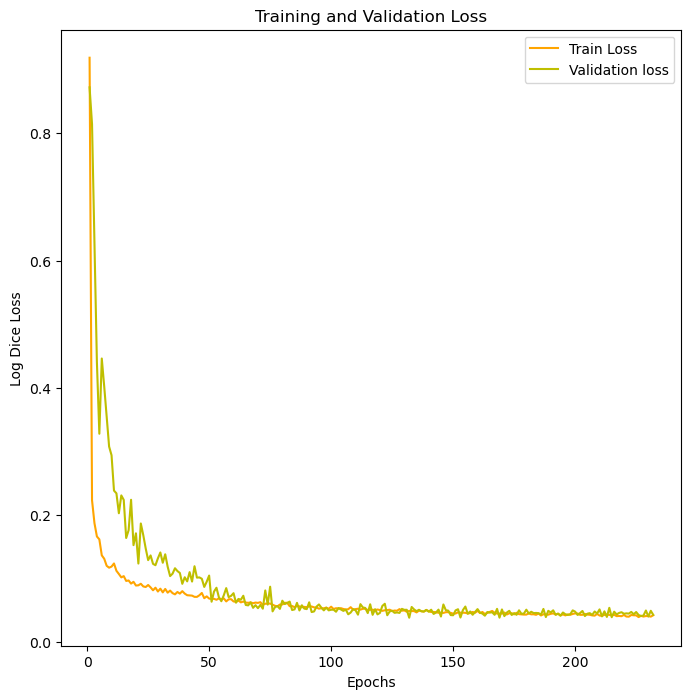

In [10]:
t_loss = history.history['loss']
val_loss = history.history['val_loss']
acc=history.history['dice_coef']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, t_loss, 'orange', label='Train Loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Dice Loss')
# plt.grid()
plt.legend()

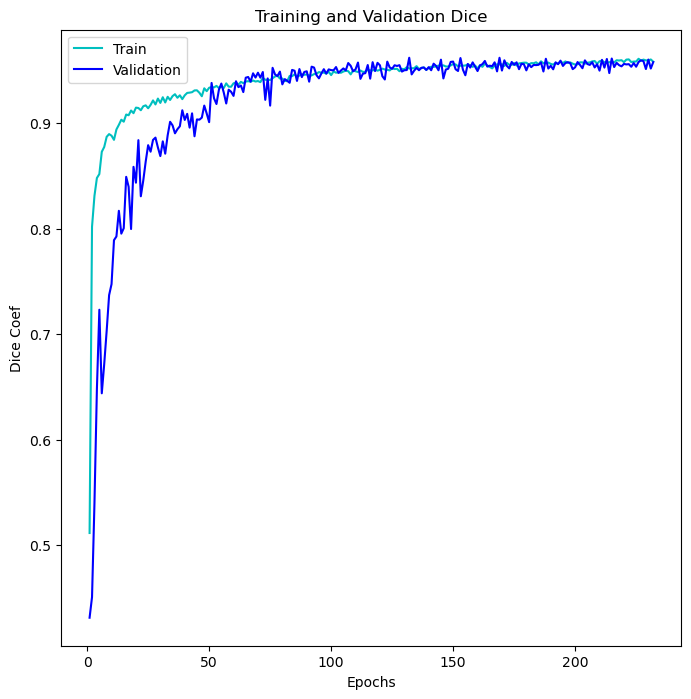

In [11]:


loss = history.history['loss']
acc=history.history['dice_coef']
val_acc=history.history['val_dice_coef']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, acc, 'c', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
# plt.grid()
plt.legend()




In [17]:
from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

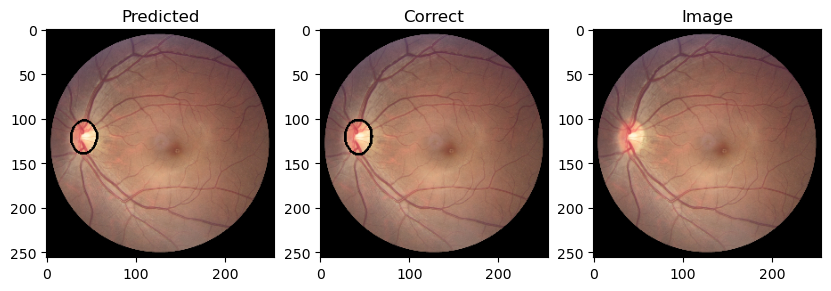

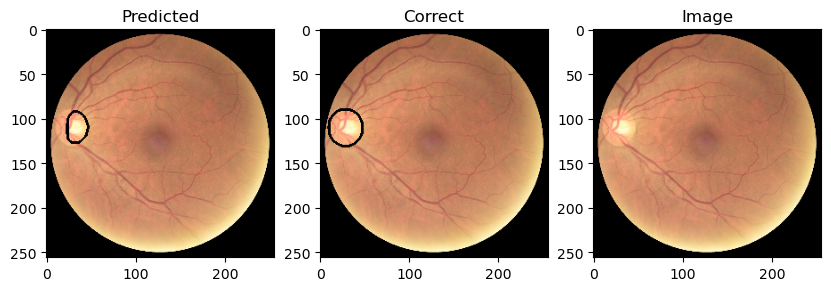

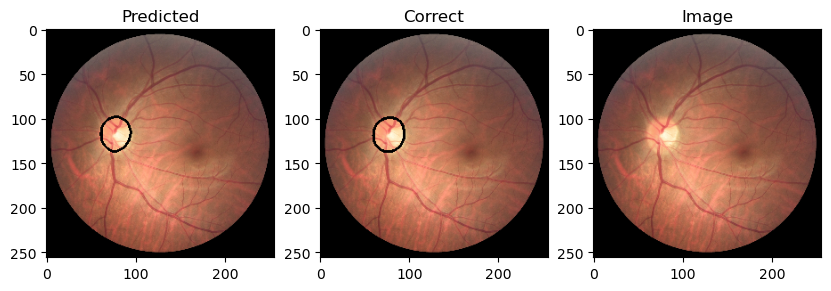

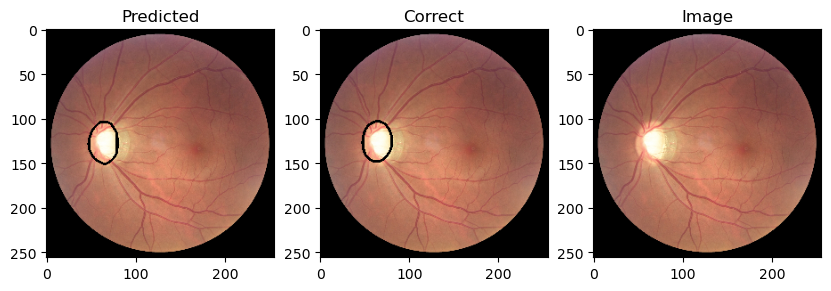

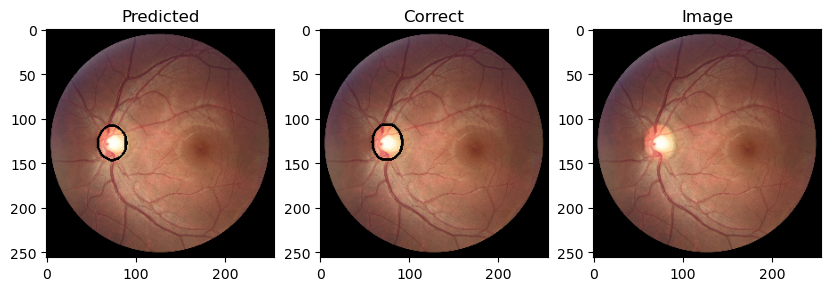

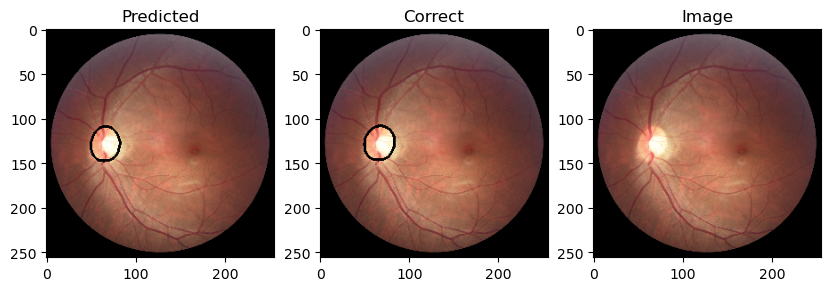

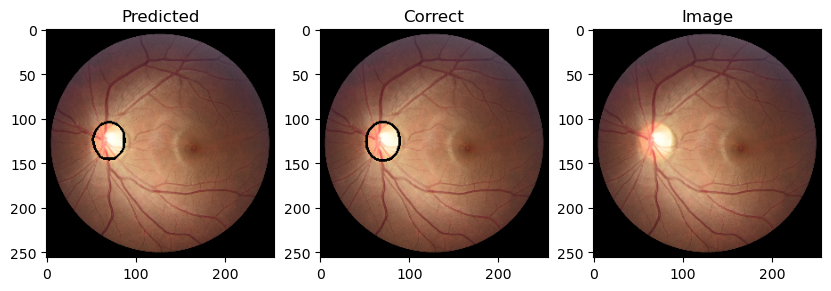

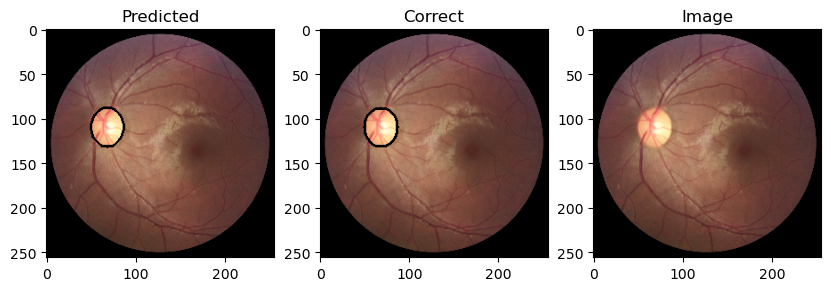

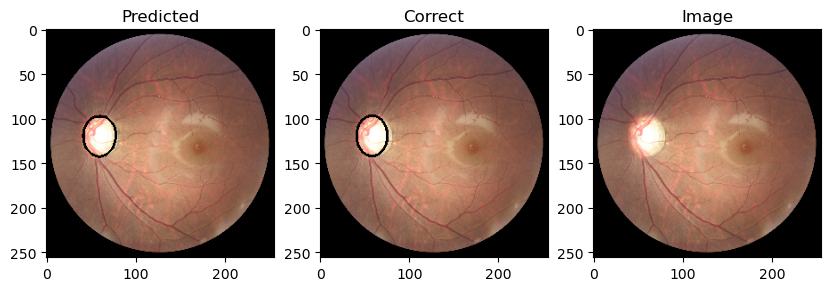

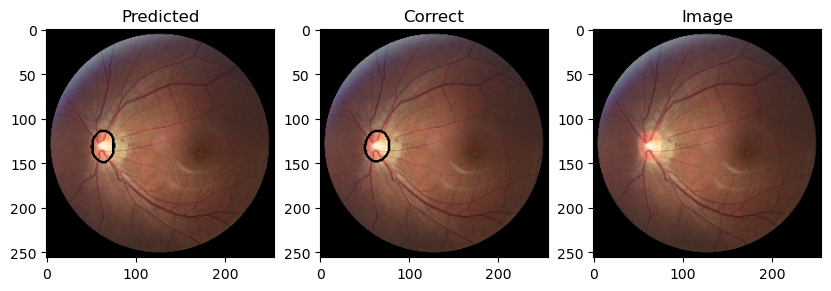

In [18]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 100) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
    edgesp = canny(pred)
    edgesp = 1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow((image*edgesp).astype(int)[:, :, ::-1])


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
    edgesc = canny(mask)
    edgesc = 1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow((image*edgesc).astype(int)[:, :, ::-1])

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])

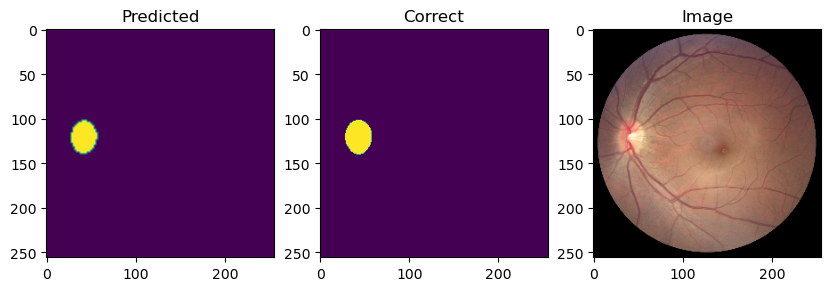

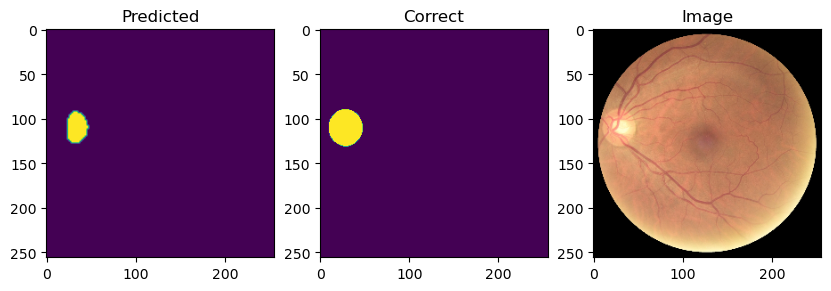

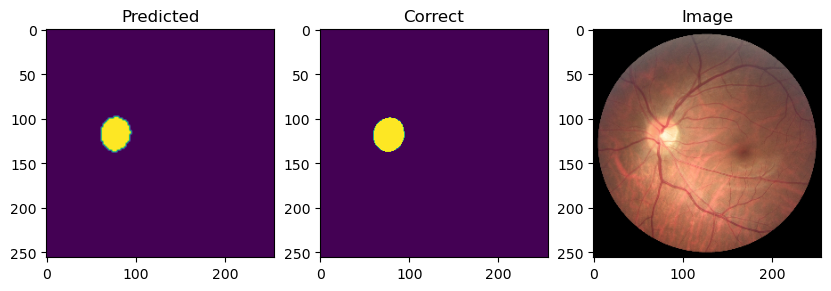

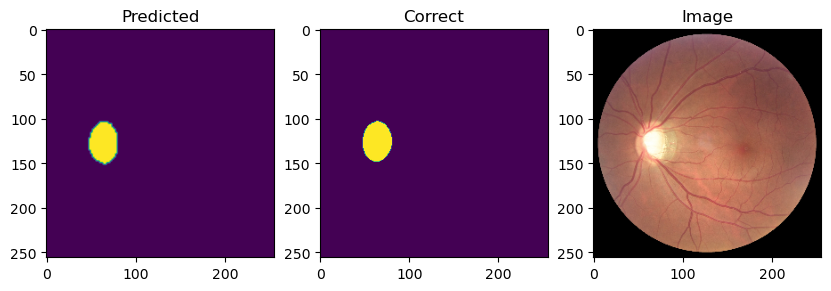

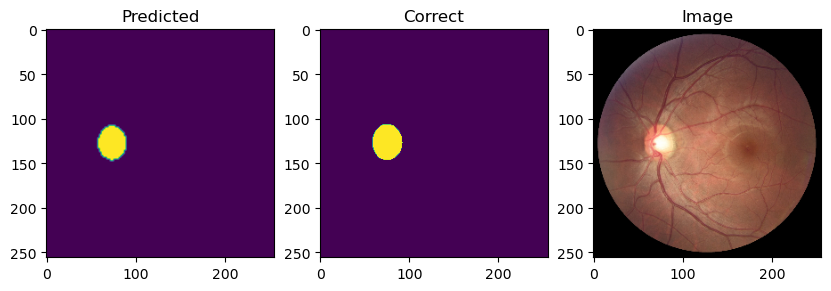

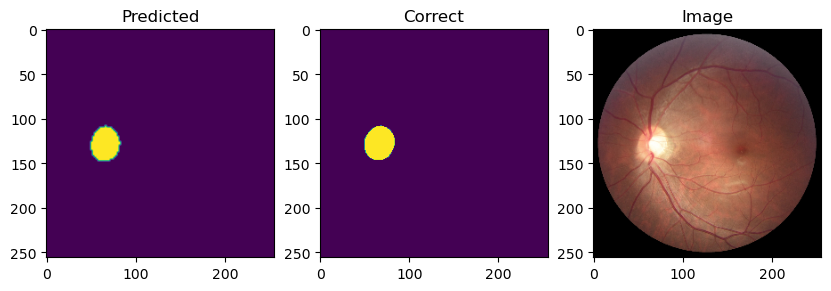

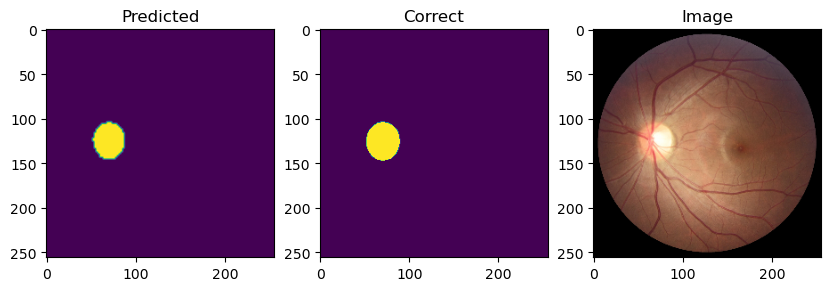

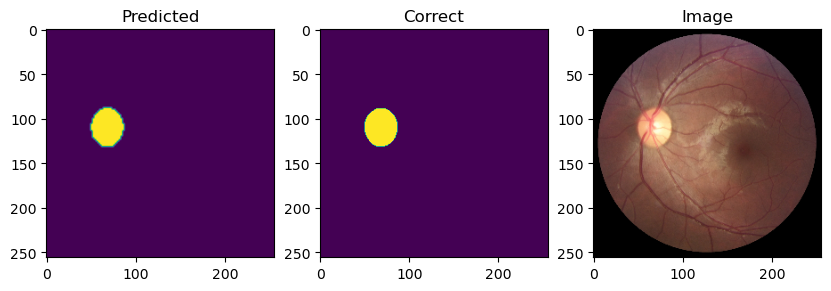

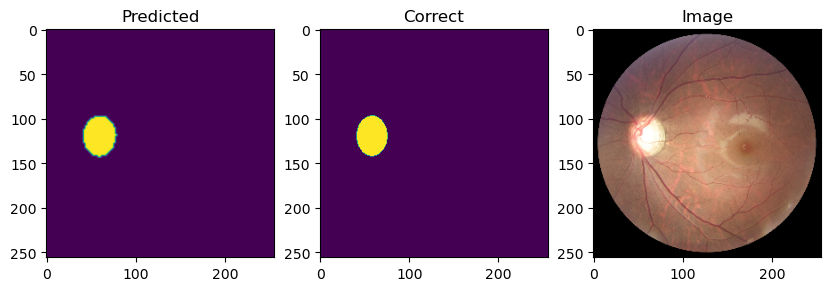

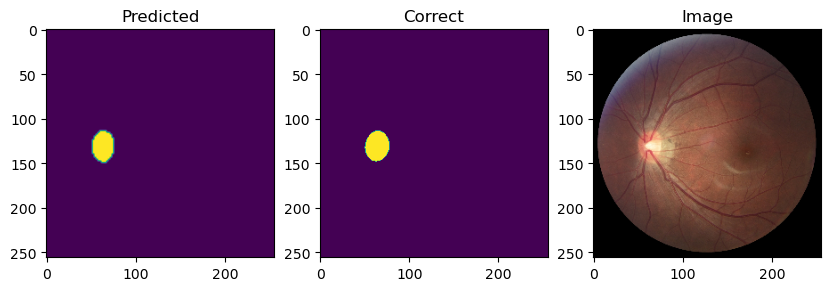

In [19]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 100) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
#     edgesp = canny(pred)
#     edgesp = 1.0-dilation(edgesp)
#     edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(pred)


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
#     edgesc = canny(mask)
#     edgesc = 1.0-dilation(edgesc)
#     edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(mask)

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])